<a href="https://colab.research.google.com/github/omerfalach/Death-Classification-FAERS/blob/main/Data_Exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
!pip install category_encoders

In [25]:
!pip install --upgrade plotly

In [26]:
!pip install squarify

In [1]:
import numpy as np
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
import pandas as pd
import pytz
import pickle
# import pycountry_convert as pc
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import make_column_transformer
from sklearn.base import BaseEstimator, TransformerMixin
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.preprocessing import LabelEncoder
import os
import warnings
import random
from sklearn.preprocessing import StandardScaler
import requests
# from category_encoders import TargetEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import StratifiedKFold, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import precision_score, roc_auc_score, recall_score, accuracy_score, make_scorer
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, roc_curve, auc,precision_recall_curve,ConfusionMatrixDisplay
import project_plots as op
import plotly.express as px
from sklearn.model_selection import StratifiedKFold
from scipy import stats
from datetime import datetime as dt
import gc

In [ ]:
# n = gc.collect()

# Loading Data

In [2]:
##connect to google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
##Loading Data
data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/dataset.csv")

In [4]:
data = data.drop(columns = ['init_fda_dt','fda_dt', 'event_dt','dechal', 'rechal', 'drug_seq'])

In [9]:
##External source
health_score = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Compliance with the International Health Regulations BY COUNTRY.csv")

In [5]:
infor =op.info_new(data,ignore_features= ['primaryid','caseid','drugname_listed','role_cod_listed','indi_pt','#drugs_to_indi'])
infor

Object types:
Ctype   float64  object
Column        2       9
X is composed of 6046950 samples and 17 features.


,colName,Non-null values,Nunique,Dtype,Unique
0,outc_cod,6046950,7,object,"[HO, LT, DE, OT, CA, DS, RI]"
1,sex,5241248,6,object,"[F, M, nan, UNK, P, T, I]"
2,age,3846136,14284,float64,"[39.0, 35.0, 54.0, nan, 65.0, 17.0, 46.0, 75.0..."
3,age_cod,3846507,6,object,"[YR, nan, DY, MON, DEC, WK, HR]"
4,age_grp,1094883,6,object,"[nan, A, C, N, T, E, I]"
5,wt,1381732,10259,float64,"[83.0, nan, 70.0, 60.8, 56.7, 90.7, 72.0, 42.0..."
6,wt_cod,1381706,2,object,"[KG, nan, LBS]"
7,occr_country,5975250,235,object,"[US, DE, GB, JP, nan, IT, NO, FR, BE, ES, CA, ..."
8,filename,6046950,27,object,"[DEMO15Q1, DEMO20Q3, DEMO15Q2, DEMO15Q3, DEMO1..."
9,drugname,6046949,65376,object,"[AVONEX, LEPONEX CLOZARIL CLOZAPINE, CLOZARIL..."


In [6]:
#normlaize age column to Years
def fixed_age(df,age,age_code):
    df.loc[(df[age]<=12) & df[age_code] == "DEC", age] = df[age]*10
    df.loc[df[age_code] == "MON", age] = df[age]/12
#     
    df.loc[df[age_code] == "MON", age] = df[age]/12
    df.loc[df[age_code]== "DY", age] = df[age]/365
    df.loc[df[age_code] == "WK", age] = df[age]/52
    df.loc[df[age_code] == "HR", age] = df[age]/8765.8127
    return df    

def fixed_weight(df,wt,wt_cod): 
        # unified weight unit
        df[wt] = df[wt].apply(pd.to_numeric, errors='coerce')
        df.loc[df[wt_cod] == "LBS", wt] = df[wt]  * 0.453592 # pounds
        df.loc[df[wt_cod]== "GMS", wt] = df[wt]* 0.001# grams
#         # weight discretization and label encode
#         wt_bins = [0, 5, 10, 40, 50, 60, 70, 80, 90, 100, 150, 200, 300]
#         demo_df['wt'] = pd.cut(demo_df.wt, wt_bins, labels=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
        return df
def fixed_label(df,label):
  df[label] = df[label].apply(lambda x: 1 if x=='DE' else 0)
  return df
def convert_str_to_list(x):
    try:
        return  x.strip('[]').replace("'", "").split(',')
    except:
        print(x)
        return np.nan # replace with any suitable placeholder value
data['indi_pt']= data['indi_pt'].apply(lambda x: convert_str_to_list(x) if type(x)!=float else x)
data['drugname_listed']= data['drugname_listed'].apply(lambda x: convert_str_to_list(x) if type(x)!=float else x)
data_fixed = fixed_age(data,'age','age_cod')
data_fixed = fixed_weight(data_fixed,'wt', 'wt_cod')
data_fixed = fixed_label(data_fixed,'outc_cod')
del data

In [7]:
gc.collect()

114

In [8]:
data_fixed['#drug_background'] = data_fixed['drugname_listed'].apply(lambda x: len(x) if type(x)!=float else x)
data_fixed['#indication_background'] = data_fixed['indi_pt'].apply(lambda x: len(x) if type(x)!=float else x)

# Outliers

In [9]:
small_categorical = ['sex','age_grp']
large_categorical = ['occr_country']
continuous = ['age','wt','#drug_background','#indication_background'] 

### Outliers - Continuous Featuers

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd516300890>,
      dtype=object)

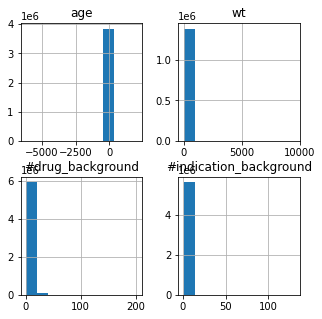

In [10]:
X_continous = data_fixed[continuous]
X_continous.hist(figsize=(5,5),bins = 10)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd509c46590>,
      dtype=object)

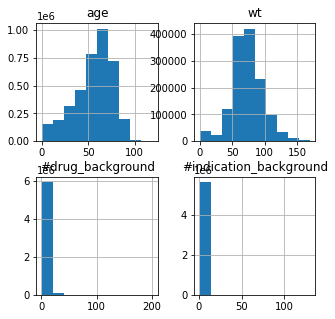

In [11]:
data_fixed.loc[(data_fixed['age']>=120) | (data_fixed['age']<=0) , 'age'] = np.nan
data_fixed.loc[(data_fixed['wt']>170), 'wt'] =  np.nan
X_continous_new = data_fixed[continuous]
X_continous_new.hist(figsize=(5,5))

### Outliers - Categorical Featuers

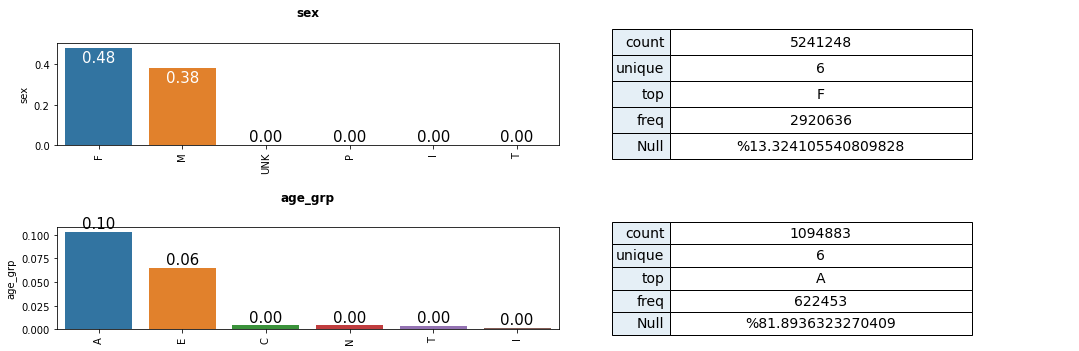

In [12]:
##small categorical
op.plot_dist(data_fixed,small_categorical)

In [13]:
sex_outliers = ['UNK','P','I','T']
data_fixed =  data_fixed[~data_fixed['sex'].isin(sex_outliers)]

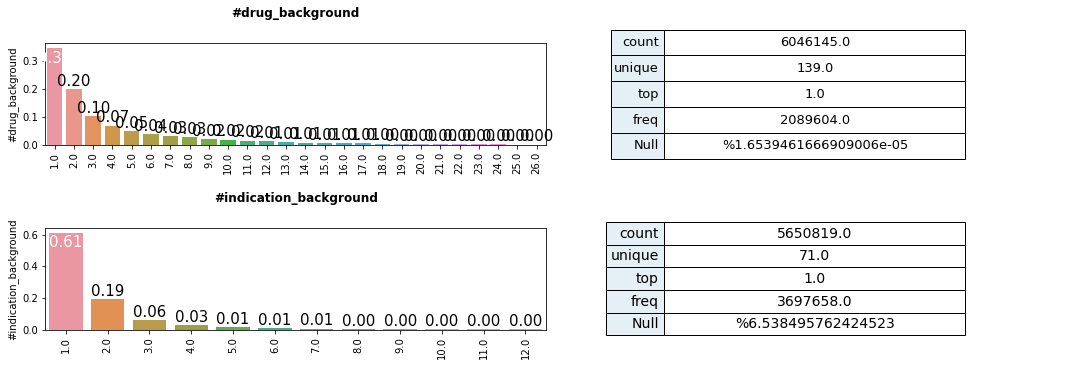

In [25]:
op.plot_dist(data_fixed,['#drug_background','#indication_background'],limit = 0.001)

# Correlation

In [15]:
def cramers_v(x, y): 
    confusion_matrix = pd.crosstab(x,y)
    chi2 = stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))
def point_biserial(x, y):

    pb = stats.pointbiserialr(x, y)
    return pb[0]

### Cont
Point biserial correlation
A point-biserial correlation is used to measure the strength and direction of the association that exists between one continuous variable and one dichotomous variable. It is a special case of the Pearson’s product-moment correlation, which is applied when you have two continuous variables, whereas in this case one of the variables is measured on a dichotomous scale [ref. ].


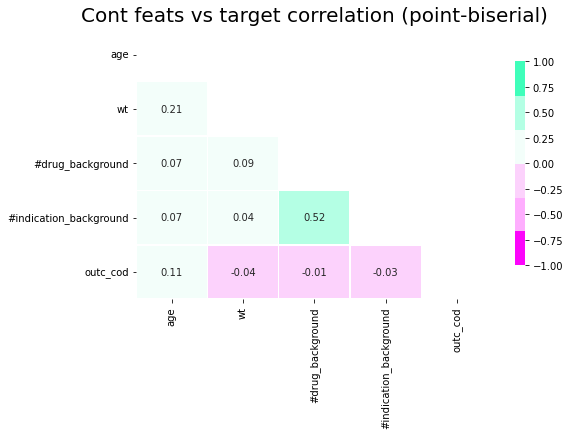

In [28]:
# data = naive_fixed_new.copy()
data = data_fixed[['primaryid', 'caseid','sex','age','wt','occr_country', 'outc_cod','#drug_background','#indication_background']].copy()
mypal= ['#FC05FB', '#FEAEFE', '#FCD2FC','#F3FEFA', '#B4FFE4','#3FFEBA']
feats_ = ['age','wt','#drug_background','#indication_background', 'outc_cod']
rows= []
for x in feats_:
    col = []
    for y in feats_ :
        if x==y:
            pbs = 1
        else:
            data1 = data[[x,y]]
            data1 = data1.dropna(subset=[x,y])
            pbs =point_biserial(data1[x], data1[y]) 
        col.append(round(pbs,2))  
    rows.append(col)  
    
pbs_results = np.array(rows)
DF = pd.DataFrame(pbs_results, columns = data[feats_].columns, index =data[feats_].columns)

mask = np.triu(np.ones_like(DF, dtype=bool))
corr = DF.mask(mask)

f, ax = plt.subplots(figsize=(8, 5), facecolor=None)
cmap = sns.color_palette(mypal, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1.0, vmin=-1, center=0, annot=True,
            square=False, linewidths=.5, cbar_kws={"shrink": 0.75})
ax.set_title("Cont feats vs target correlation (point-biserial)", fontsize=20, y= 1.05);

### Cat
Cramer's V correlation
In statistics, Cramér's V is a measure of association between two nominal variables, giving a value between 0 and +1 (inclusive). It is based on Pearson's chi-squared statistic and was published by Harald Cramér in 1946. [ref. ]

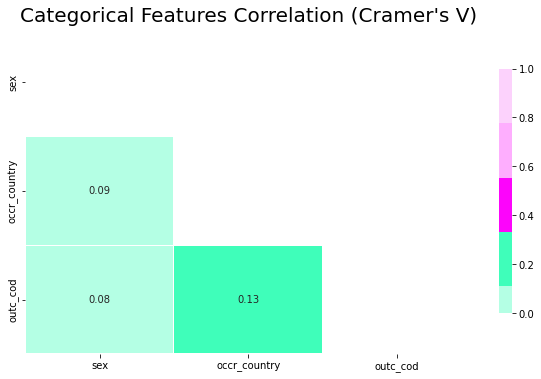

In [29]:
# calculate the correlation coefficients using the above function
cat_feats = ['sex','occr_country','outc_cod']
data_ = data_fixed[cat_feats].copy()
rows= []
for x in data_:
    col = []
    for y in data_ :
        cramers =cramers_v(data_[x], data_[y]) 
        col.append(round(cramers,2))
    rows.append(col)
    
cramers_results = np.array(rows)
df = pd.DataFrame(cramers_results, columns = data_.columns, index = data_.columns)

# color palette 
mypal_1= ['#FC05FB', '#FEAEFE', '#FCD2FC','#F3FEFA', '#B4FFE4','#3FFEBA', '#FC05FB', '#FEAEFE', '#FCD2FC']
# plot the heat map
mask = np.triu(np.ones_like(df, dtype=bool))
corr = df.mask(mask)
f, ax = plt.subplots(figsize=(10, 6), facecolor=None)
cmap = sns.color_palette(mypal_1, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1.0, vmin=0, center=0, annot=True,
            square=False, linewidths=.01, cbar_kws={"shrink": 0.75})
ax.set_title("Categorical Features Correlation (Cramer's V)", fontsize=20, y= 1.05);

In [16]:
data_fixed.head(10)

,primaryid,caseid,outc_cod,sex,age,age_cod,age_grp,wt,wt_cod,occr_country,filename,drugname,role_cod,drugname_listed,role_cod_listed,indi_pt,#drugs_to_indi,#drug_background,#indication_background
0,35032933,3503293,0,F,39.0,YR,NaN,83.0,KG,US,DEMO15Q1,AVONEX,PS,"[AVONEX, AVONEX, ZOLOFT, LIPITOR, SYNTHROI...","['PS', 'SS', 'C', 'C', 'C', 'C', 'C']","[Benign neoplasm of thyroid gland, Depression...","[1, 3, 1, 2]",7.0,4.0
1,36655882,3665588,0,F,35.0,YR,NaN,NaN,NaN,DE,DEMO15Q1,LEPONEX CLOZARIL CLOZAPINE,PS,"[LEPONEX CLOZARIL CLOZAPINE, CARBAMAZEPINE, ...","['PS', 'SS', 'SS']",[Schizoaffective disorder],[3],3.0,1.0
2,38671183,3867118,0,F,54.0,YR,NaN,70.0,KG,US,DEMO15Q1,AVONEX,PS,"[AVONEX, ACETAMINOPHEN]","['PS', 'C']","[Influenza like illness, Multiple sclerosis]","[1, 1]",2.0,2.0
3,38775713,3877571,0,M,NaN,NaN,NaN,NaN,NaN,GB,DEMO15Q1,CLOZARIL,PS,[CLOZARIL],['PS'],[Schizophrenia],[1],1.0,1.0
4,40954634,4095463,1,F,65.0,YR,NaN,NaN,NaN,JP,DEMO15Q1,GLIVEC,PS,"[GLIVEC, GLIVEC, CYLOCIDE, LASIX, FOY]","['PS', 'SS', 'SS', 'C', 'C']","[Acute kidney injury, Blast cell crisis, Bla...","[1, 1, 1, 1, 1]",5.0,5.0
5,41149942,4114994,0,F,17.0,YR,A,NaN,NaN,NaN,DEMO15Q1,TACROLIMUS,PS,"[TACROLIMUS, AZATHIOPRINE, UNSPECIFIED INGRE...","['PS', 'C', 'C', 'C', 'C', 'C', 'C']",[Liver transplant],[1],7.0,1.0
6,41352566,4135256,0,F,46.0,YR,NaN,NaN,NaN,US,DEMO15Q1,AVONEX,PS,"[AVONEX, AVONEX, RITALIN, WELLBUTRIN, REME...","['PS', 'SS', 'C', 'C', 'C', 'C', 'C', 'C', 'C']","[Contraception, Hypothyroidism, Multiple scl...","[1, 1, 5]",9.0,3.0
7,41943882,4194388,0,F,75.0,YR,NaN,60.8,KG,NaN,DEMO15Q1,PREVACID,PS,"[PREVACID, SYNTHROID, FOSAMAX]","['PS', 'C', 'C']",[Gastrooesophageal reflux disease],[1],3.0,1.0
8,42207644,4220764,0,F,18.0,YR,A,NaN,NaN,US,DEMO15Q1,ENBREL,PS,[ENBREL],['PS'],[Psoriasis],[1],1.0,1.0
9,57166203,5716620,0,M,54.0,YR,NaN,NaN,NaN,US,DEMO15Q1,AVONEX,PS,"[AVONEX, AVONEX]","['PS', 'SS']",[Multiple sclerosis],[3],2.0,1.0


# Correlation to Label

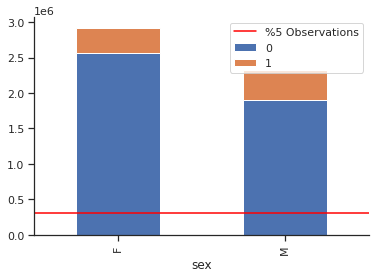

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


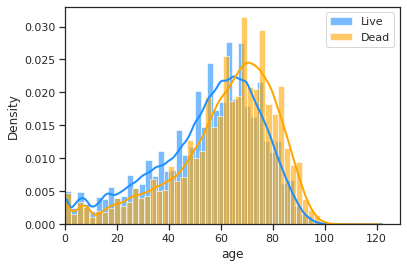

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


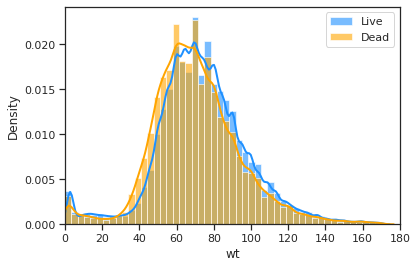

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


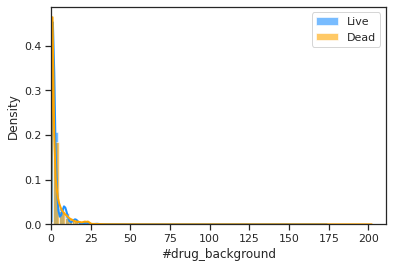

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


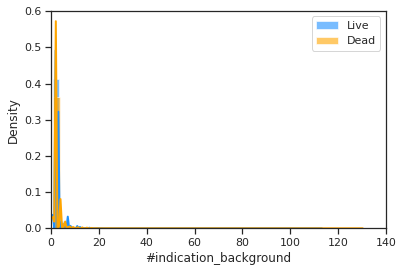

In [18]:
# Small_CATEGORICAL_FEATURES = ['sex','#drug_background','#indication_background']

Small_CATEGORICAL_FEATURES = ['sex']

ignore_list = ['primaryid','caseid','outc_cod','occr_country','role_cod_listed','#drugs_to_indi','drugname','drugname_listed','indi_pt','wt_cod','role_cod','age_grp','age_cod','filename']
for col in data_fixed.columns:
    if col in ignore_list:
        continue
    elif col in Small_CATEGORICAL_FEATURES:
        op.plot_label_corr_bar(data_fixed, col)
    else:
        op.plot_label_corr_hist(data_fixed, col)

In [20]:
import project_plots_n as op
op.treemap(data_fixed,'drugname','outc_cod')


In [21]:
op.treemap(data_fixed,'occr_country','outc_cod')

# Missing Values

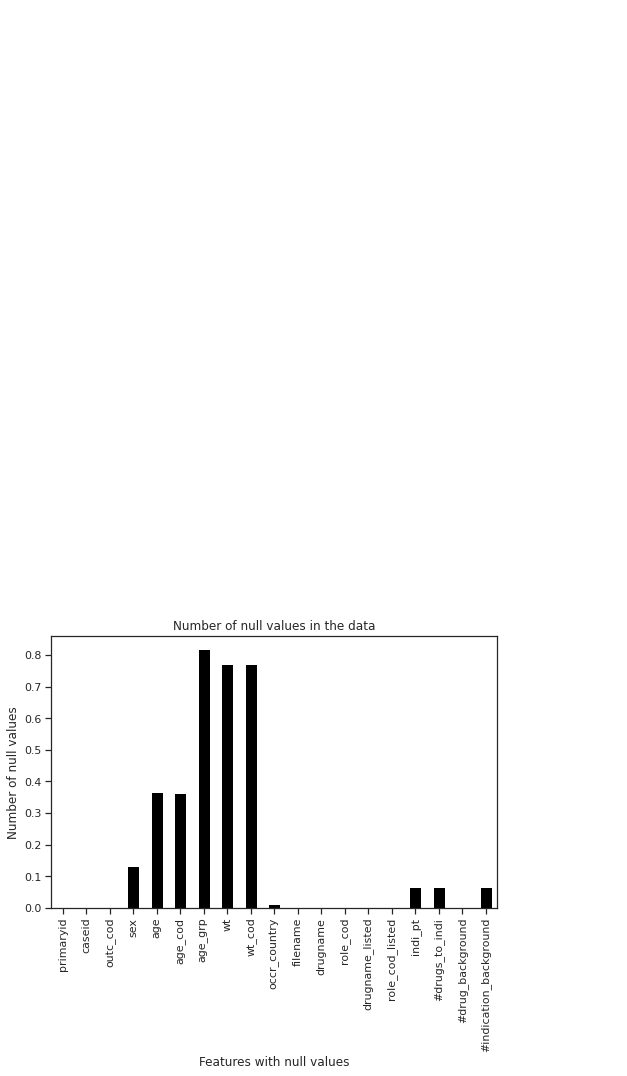

In [23]:
X1 = data_fixed.copy()
fig = plt.figure(figsize=(8, 5))
ax = X1 .isna().mean().plot(kind='bar',color='black')
for p in ax.patches:
    ax.annotate(p.get_height(), (p.get_x(), p.get_height()+2))
ax.set_title('Number of null values in the data')
ax.set_xlabel('Features with null values')
ax.set_ylabel('Number of null values')
plt.show()

# Data Balance

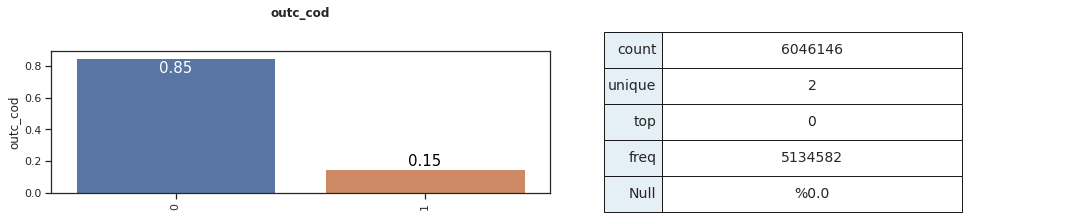

In [18]:
op.plot_dist(data_fixed,['outc_cod'])

# Split Train-Test

In [24]:
data_fixed= data_fixed.dropna(subset=['outc_cod', 'occr_country','drugname_listed','indi_pt'])
naivefstra = data_fixed.drop(columns = ['primaryid','caseid','wt_cod','role_cod','age_grp','age_cod','wt','#drugs_to_indi'])
del data_fixed
gc.collect()


82723

In [25]:
naivefstra['outc_cod'] = naivefstra['outc_cod'].astype(int)
def get_stratified_split(x,y,test_size = 0.2):
    n_folds = int(round(1/test_size))
    skf = StratifiedKFold(n_splits = n_folds, random_state = 0, shuffle = True)
    for tr_ind, test_ind in skf.split(x,y):
        break
    return tr_ind,test_ind

tr_ind, test_ind = get_stratified_split(np.zeros(len(naivefstra)),naivefstra['outc_cod'],test_size =0.2)
features = list(naivefstra.columns)
features.remove('outc_cod')
train_features = naivefstra[features].iloc[tr_ind]
test_features = naivefstra[features].iloc[test_ind]
train_labels = naivefstra['outc_cod'].iloc[tr_ind]
test_labels = naivefstra['outc_cod'].iloc[test_ind]

In [ ]:
#last_version_includes_indications
# train_features.to_csv('/content/drive/MyDrive/Colab Notebooks/train_features1.csv',index = False)
# test_features.to_csv('/content/drive/MyDrive/Colab Notebooks/test_features1.csv',index = False)
# train_labels.to_csv('/content/drive/MyDrive/Colab Notebooks/train_labels1.csv',index = False)
# test_labels.to_csv('/content/drive/MyDrive/Colab Notebooks/test_labels1.csv',index = False)

In [ ]:
# train_features= pd.read_csv('/content/drive/MyDrive/Colab Notebooks/train_features1.csv')
# test_features= pd.read_csv('/content/drive/MyDrive/Colab Notebooks/test_features1.csv')
# train_labels= pd.read_csv('/content/drive/MyDrive/Colab Notebooks/train_labels1.csv')
# test_labels= pd.read_csv('/content/drive/MyDrive/Colab Notebooks/test_labels1.csv')